# Word2vec


***


This notebook, you will work with the Word2Vec model.
* In the first part we will implement a simple word game based on semantic similarity.
* In the second part, your task is to train a Word2Vec model from scratch based on the news data we introduced in last exercise session, apply dimensionality reduction to the resulting embeddings, and plot word pairs similar to the analysis in the Word2Vec paper to reproduce their results.
* In the third part, you will work with a Doc2vec model that produces document-vectors (instead of word vectors) and apply k-means clustering to the resulting document embeddings to create groups of articles based on their contents.

In [1]:
# Packages for part 1
from gensim import utils
from sklearn.decomposition import PCA
from time import time  
import gensim.models
import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
import json


# Packages for part 2
from scipy.spatial.distance import cosine
from sklearn import cluster
import plotly.express as px
from sklearn import preprocessing
import pandas as pd
import re

In [2]:
# Determine number of cpu cores
import multiprocessing
cores = multiprocessing.cpu_count()

## Task 1: Word Analogy Game

In last week's assignment, you evaluated a GloVe model for word analogy tasks. In [this week's paper](https://arxiv.org/abs/1310.4546), the authors mention the underlying concept we used to find related words: Additive Compositionality. To recall our findings from last week's assignment and as an introduction to python classes, we ask you to implement a "*Wordle* competitor", a currently popular word game. But in contrast to *Wordle*, we will use vector representations and semantic similarity. 


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Load the Dataset</b> 
</div>

First, we will download our evaluation data set ("wordsim353") containing word pairs labelled by humans in terms of their similarity. To access the data, add [this](https://www.kaggle.com/datasets/julianschelb/wordsim353-crowd) dataset to your notebook. 

**How to add data to a notebook?**

* Click on "+ Add data" (in the top-right)
* Search for "WordSim353 (crowd)" 
* Use the "plus" button next to the datasets title

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Implement a Simple Word Game</b> 
</div>

Make yourself familiar with the structure of [python classes](https://docs.python.org/3/tutorial/classes.html). Make sure you have at least a basic understanding about how classes and objects relate, what a constructor is and how to implement methods. You will use python classes to for creating training corpora later. 

The goal of this game is to solve word analogies by guessing the fourth word. We will use the same dataset we used in last week's assignment. Players guess the correct word. The player with the best answer wins one round. The player who wins the mst rounds wins the game. We ask you to complete the provided class definition. The game should fulfil the following criteria: 

1. Multiple players can compete over multiple rounds. 
2. In every round:

    * Select one random question from dataset.
    * Present the first three words to the players.
    * Let each player guess the fourth word.
    * Calculate the similarity between every answer and the correct word in the dataset.
    * Determine which player's answer was the best.
    
    
3. Determine which player did win.
    
    
*(Hint: You can use the [input()](https://docs.python.org/3/library/functions.html?highlight=input#input) function to allow players to type in their answer.)*

In [3]:
# Load the dataset 
questions = pd.read_csv("../input/word-analogy-test/questions-words.csv")

# Preprocess the dataset
questions = questions.applymap(lambda token: token.lower() if type(token) == str else token)

# Load the model 
model_wiki = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [4]:
class Wordgame():
    """A simple word game using vector representations."""
    
    def __init__(self, players = [], rounds = 10, questions = None, model = None):
        self.players = players
        self.rounds = rounds
        self.scores = [0 for player in players]
        self.questions = questions
        self.model = model
        
        # Start the game
        # self.playGame()
        
    def playGame(self):
        
        # Play n rounds
        for round_id in range(0, self.rounds):
            self.playRound(round_id)
            
        # Display final score
        print("\nFINAL SCORE:")
        print("\nPlayer \t Score")
        print("-----------------------------------")
        for player, score in zip(self.players, self.scores):
            print("{:6} \t {:6} \t".format(player, score))
            
        
    def playRound(self, round_id):
        
        print("\n--------------------------------------------------")
        print("----------------- ROUND {} OF {} -----------------".format(round_id, self.rounds))
        print("--------------------------------------------------\n")
        
        # Randomly select question
        question = self.questions.sample(n=1) 
        question = question.iloc[0]
        solution = str(question["word_four"])
        w1 = str(question["word_one"])      
        w2 = str(question["word_two"])
        w3 = str(question["word_three"])
        print(f"Question: '{w1}' is to '{w2}' like '{w3}' is to ??? \n")
        
        answers = []
        similarities = []
        
        # Ask every player
        for player in self.players:
            
            # Ask until answers is valid
            answer_valid = False
            while not answer_valid:
                answer = input("Player {}, what is your guess?".format(player))
                answer = answer.lower()
                answers.append(answer)
                answer_valid = answer in self.model 
                
            # Determine similarity between answer and solution
            similarity = self.model.similarity(solution, answer)
            similarities.append(float(similarity))
            
        # Display answers
        print("\nPlayer \t Answer \t Similarity")
        print("-----------------------------------")
        for player, answer, similarity in zip(self.players, answers, similarities):
            print("{:6} \t {:6} \t {}".format(player, answer, round(similarity, 4)))
           
        # Determine best answers
        max_sim = max(similarities)
        max_index = similarities.index(max_sim)
        best_player = self.players[max_index]
        self.scores[max_index] = self.scores[max_index] + 1
        print(f"\n{best_player}\'s answer was the best!\n")
        
        return True
        

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 3: Test your Implementation</b> 
</div>

Test your implementation by playing a match. **If you use the [input()](https://docs.python.org/3/library/functions.html?highlight=input#input) function, copy the output into a separate text cell and comment out the actual python commands. Otherwise the notebook will expect an input and consequently fail when running in the background after using "Save & Run all".** 

In [5]:
# game = Wordgame(["Alice", "Bob", "Carol"], 2, questions, model_wiki)
# game.playGame()

## Task 2: Word2vec

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Load the Dataset</b> 
</div>

First, you need to add [this](https://www.kaggle.com/datasets/julianschelb/newsdata) news dataset to your notebook. Click on "+Add data" and the dataset. In the next step, please implement the following steps to load the data and pre-process it:

* Use the provided code snippet to load the data.
* Iterate over the articles, remove all line breaks ("\n"), and store every article's body in a list. (*Hint:* the keys referring to the body of an article vary. You will need "body" and "text" as keys to get all bodies)

In [6]:
# Read article data
with open("../input/newsdata/relevant_articles.json","rb") as d:
    relevant_articles = json.load(d)

In [7]:
# Preprocess data
articles = pd.json_normalize(relevant_articles)

# Preprocess text
articles["text"] = articles["text"].replace('\n', '')
articles["text_lower"] = articles["text"].str.lower()
print("Articles extracted:", len(articles["text_lower"] ))

# Have a peek
articles.head()

Articles extracted: 60795


,_id,url,title,feed,type,lang,refs,sum,body,text,pub.$date,ret.$date,auth,text_lower
0,197727,http://www.theguardian.com/housing-network/201...,Five steps to fixing the UK housing crisis in ...,guardian,politics,en,[http://www.theguardian.com/commentisfree/2015...,Headlines about the utter madness of our housi...,Perhaps in years to come 2015 will be remember...,Headlines about the utter madness of our housi...,2016-01-01T09:12:27.000+0000,2016-01-01T09:27:32.000+0000,NaN,headlines about the utter madness of our housi...
1,197728,http://www.theguardian.com/commentisfree/2016/...,That’s enough assessments of 2015. It’s time t...,guardian,politics,en,"[http://www.theguardian.com/business/davos, ht...",From Strictly Come Dancing featuring Vladimir ...,• Jeremy Corbyn turns down invitation to atten...,From Strictly Come Dancing featuring Vladimir ...,2016-01-01T09:37:06.000+0000,2016-01-01T09:47:42.000+0000,NaN,from strictly come dancing featuring vladimir ...
2,197995,http://www.theguardian.com/politics/2016/jan/0...,The paperback memoirs of Miss Rice-Davies : ar...,guardian,politics,en,[http://www.theguardian.com/politics/2014/dec/...,1 January 1964 : The Mandy Report turns out to...,"Miss Mandy Rice-Davies, one of 1963’s better k...",1 January 1964 : The Mandy Report turns out to...,2016-01-01T05:00:22.000+0000,2016-01-01T22:59:09.000+0000,NaN,1 january 1964 : the mandy report turns out to...
3,198038,http://www.bbc.co.uk/news/uk-scotland-35210821...,'Very drunk' patient numbers revealed,bbc,politics,en,[http://www.bbc.co.uk/news/uk-scotland-35097230],Ambulances attend more than 60 incidents on av...,"Paramedics treated about 12,000 people who wer...",Ambulances attend more than 60 incidents on av...,2016-01-02T00:42:46.000+0000,2016-01-02T00:45:47.000+0000,NaN,ambulances attend more than 60 incidents on av...
4,198046,http://www.bbc.co.uk/news/uk-35212696#sa-ns_mc...,Littering fines set to rise to £150,bbc,politics,en,[http://www.telegraph.co.uk/news/politics/1206...,Penalties for people who drop litter could rea...,"According to the Daily Telegraph, the minimum ...",Penalties for people who drop litter could rea...,2016-01-02T04:28:41.000+0000,2016-01-02T04:47:52.000+0000,NaN,penalties for people who drop litter could rea...


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Train a Model</b> 
</div>

Next, we ask you to train a Word2Vec model on the news data with the gensim api. Refer to the [gensim documentation](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html) for detailed information.


Please implement the following steps:
- Create an iterator class for data loading as instructed in the "[Training your own model](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#training-your-own-model)" section on the above website. The class should take your data from Step 1 as input and return one article per iteration.
- Train a Word2Vec model as instructed on the website with default parameters on all articles. This might take ~15 minutes.
- Keep track of the training loss per epoch using [callbacks](https://radimrehurek.com/gensim/models/callbacks.html). You can use [model.get_latest_training_loss()](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec.get_latest_training_loss) to get the cumulative training loss. 
- Plot the training loss per epoch.
- *Recommended:* to subsequently save time, you can also save the model as instructed on the website and add it as Dataset to your input folder. Once you re-open the notebook, you can load the model from your input folder avoiding repeating training.

In [8]:
# Implement iterator class
class MyCorpus():
    """An iterator that yields sentences (lists of str)."""
    
    def __init__(self, articles):
        self.articles = articles
    
    def __iter__(self):
        for article in self.articles:
            # Assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(article)

In [9]:
from gensim.models.callbacks import CallbackAny2Vec

class LossLogger(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0
        self.loss_per_epoch = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_per_epoch.append(loss_now)
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

In [10]:
# Create model object
model = gensim.models.Word2Vec(workers=cores)

# Building the vocabulary from our dataset
sentences = MyCorpus(list(articles["text_lower"])) #.sample(n=1000)
model.build_vocab(sentences, progress_per=100)

# Create callback instances
loss_logger = LossLogger()

# Train the model
start_time = time()
model.train(sentences, 
            total_examples=model.corpus_count, 
            compute_loss=True, epochs=model.epochs, 
            callbacks=[loss_logger])

print('Total Training Time: {} mins'.format(round((time() - start_time) / 60, 2)))

Loss after epoch 0: 37428788.0
Loss after epoch 1: 20962020.0
Loss after epoch 2: 10269688.0
Loss after epoch 3: 2387912.0
Loss after epoch 4: 1906312.0
Total Training Time: 11.78 mins


In [11]:
# Loss per epoch as line plot
fig = px.line(
    x=range(1, len(loss_logger.loss_per_epoch) + 1), 
    y=loss_logger.loss_per_epoch,
    labels={'x': 'Epoch', 'y': 'Loss'},
    title='Loss per Epoch during Training',
    markers=True
)

# Force the x-axis (Epochs) to have integer labels
fig.update_xaxes(tickmode='linear', tick0=1, dtick=1)

# Show the plot
fig.show()

In [12]:
# Train model with default parameters
#sentences = MyCorpus(list(articles["text_lower"]))
#model = gensim.models.Word2Vec(sentences=sentences)

In [13]:
# Recommended: save model
model.save("word2vec_model.h5")
model = gensim.models.Word2Vec.load("./word2vec_model.h5")

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 3: Visualize Relations</b> 
</div>

Next, we ask you to reproduce Figure 2 from the word vectors paper by using your trained Word2Vec model. Please implement the following steps:

* Retrieve word embeddings from the pretrained model for the country/capital word pairs indicated in list below.
* Reduce the dimensionality of word embeddings: apply a principal component analysis (PCA) to reduce the dimensionality of the embeddings from step 1 to d = 2. Use the sklearn package here.
Plot the first two components as a scatterplot and connect both words of each word pair pairs by a line to indicate their relationship.
* Discuss your results.

In [14]:
# Pre-defined list of word pairs
countries_capitals = [('china', 'beijing'),('russia', 'moscow'),('japan', 'tokyo'),
                      ('poland', 'warsaw'),('germany', 'berlin'),('france','paris'),
                      ('italy', 'rome'), ('greece', 'athens'),('spain', 'madrid')]

In [15]:
# Get word embeddings for words in countries_capitals list and apply PCA

def getWordPairEmbeddings(word_pairs, model):
    """Use Word2vec to obtain word embeddings."""
    
    tokens = []
    embeddings = []

    for word_pair in word_pairs:
        tokens.append(word_pair[0])
        embeddings.append(model.wv[word_pair[0]])
        tokens.append(word_pair[1])
        embeddings.append(model.wv[word_pair[1]])
        
    return tokens, embeddings

In [16]:
def reduceDimensionality(embeddings, n = 2): 
    """Reduce the dimensionality of embeddings (e.g. for plotting)"""
    
    pca = PCA(n_components=n)
    pca.fit(embeddings)
    embeddings_transformed = pca.transform(embeddings)
    return embeddings_transformed

In [17]:
# Plot first two components as scatterplot and connect word pairs by line

def plotWordPair(embeddings, word_pairs):
    """ Plots relations of word pairs"""
    
    plt.rcParams["figure.figsize"] = (20,15)
    plt.scatter(x = embeddings[:,1], y = embeddings[:,0])

    for i, embedding in enumerate(embeddings):
        plt.annotate(tokens[i], (embedding[1], embedding[0]),
                     xytext=(embedding[1] + 0.1, embedding[0]),
                     fontsize=14)

    for i in range(0, len(word_pairs)):   
        plt.arrow(x = embeddings[i * 2][1], y = embeddings[i * 2][0],
                  dx = embeddings[i * 2 + 1][1] - embeddings[i * 2][1], 
                  dy = embeddings[i * 2 + 1][0] - embeddings[i * 2][0], 
                alpha = 0.3)

    plt.show()

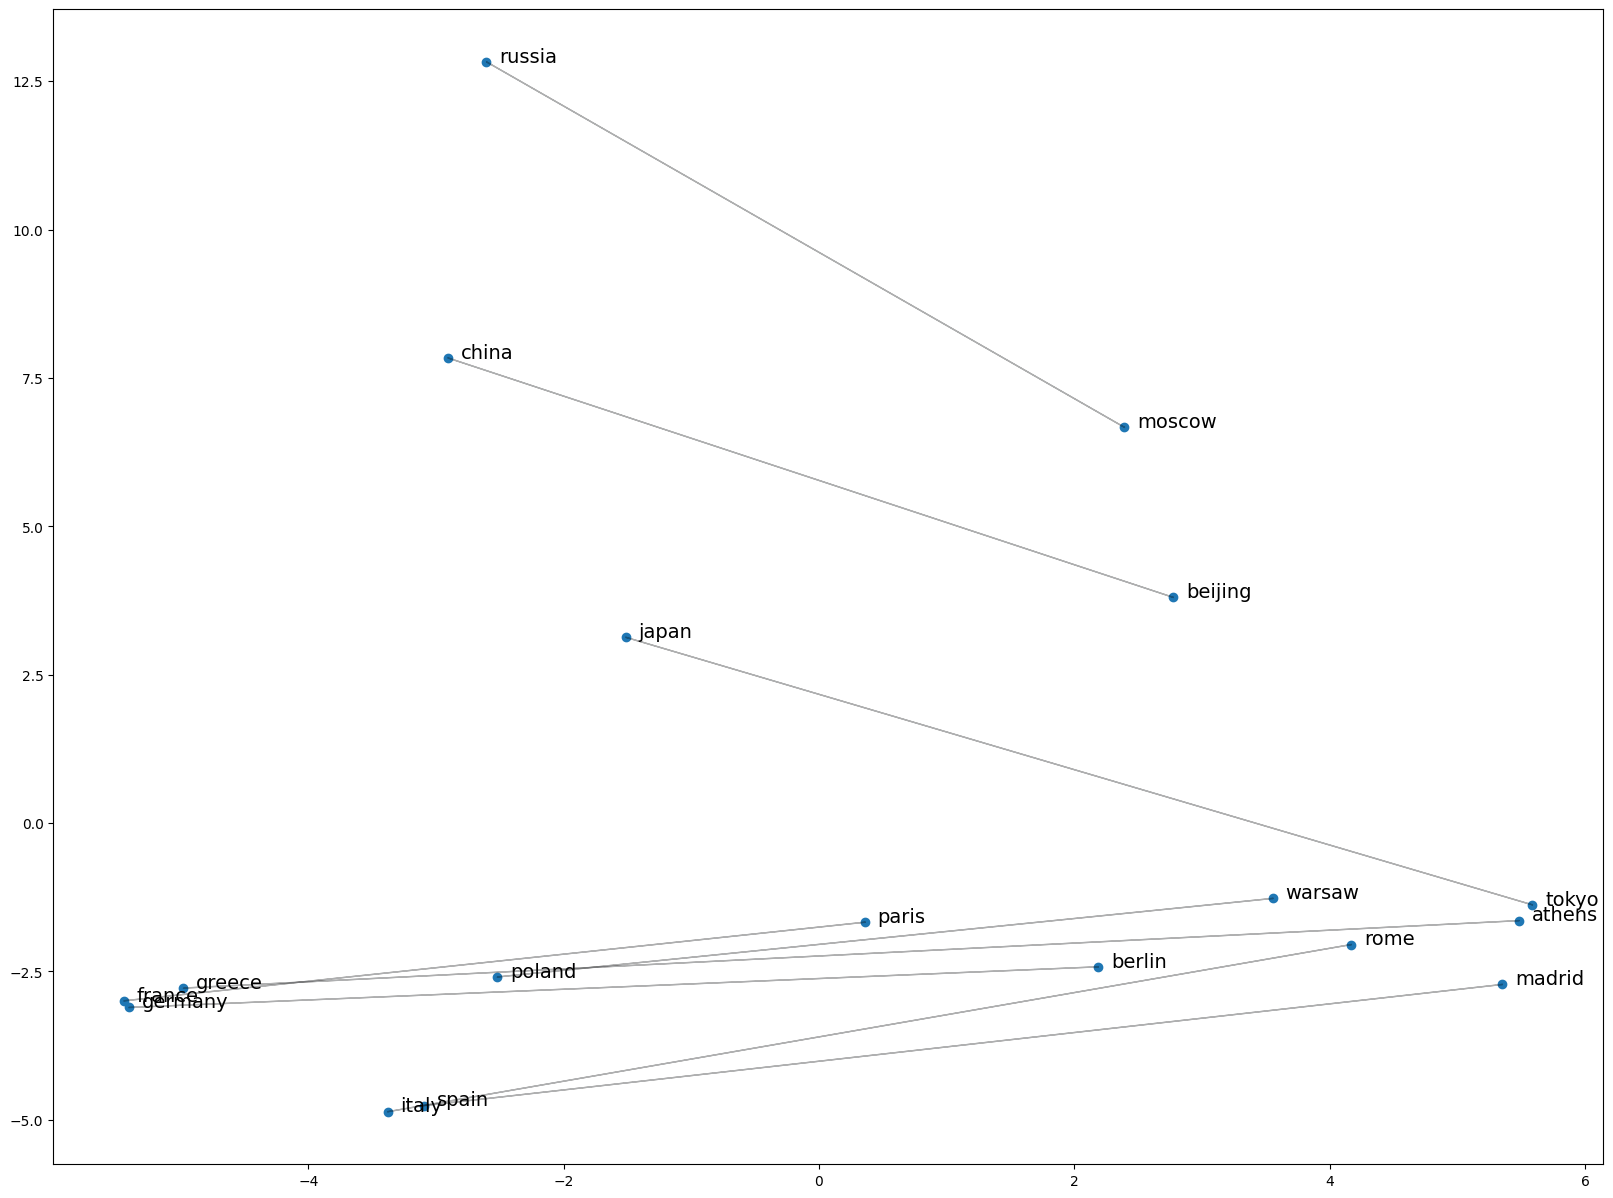

In [18]:
# Obtain embeddings, apply PCA and plot word pair relations
tokens, embeddings = getWordPairEmbeddings(countries_capitals, model)
embeddings_reduced = reduceDimensionality(embeddings, n = 2)
plotWordPair(embeddings_reduced, countries_capitals)

In analogy to the previous task, plot PCA-reduced embeddings (first two components) of for the embeddings corresponding to the following list of 
Countries/Heads of State and discuss your results.

In [19]:
# Pre-defined list of word pairs
countries_HoS = [('china', 'ping'),('russia', 'putin'),('turkey', 'erdogan'),
         ('germany', 'merkel'),('france','macron')]

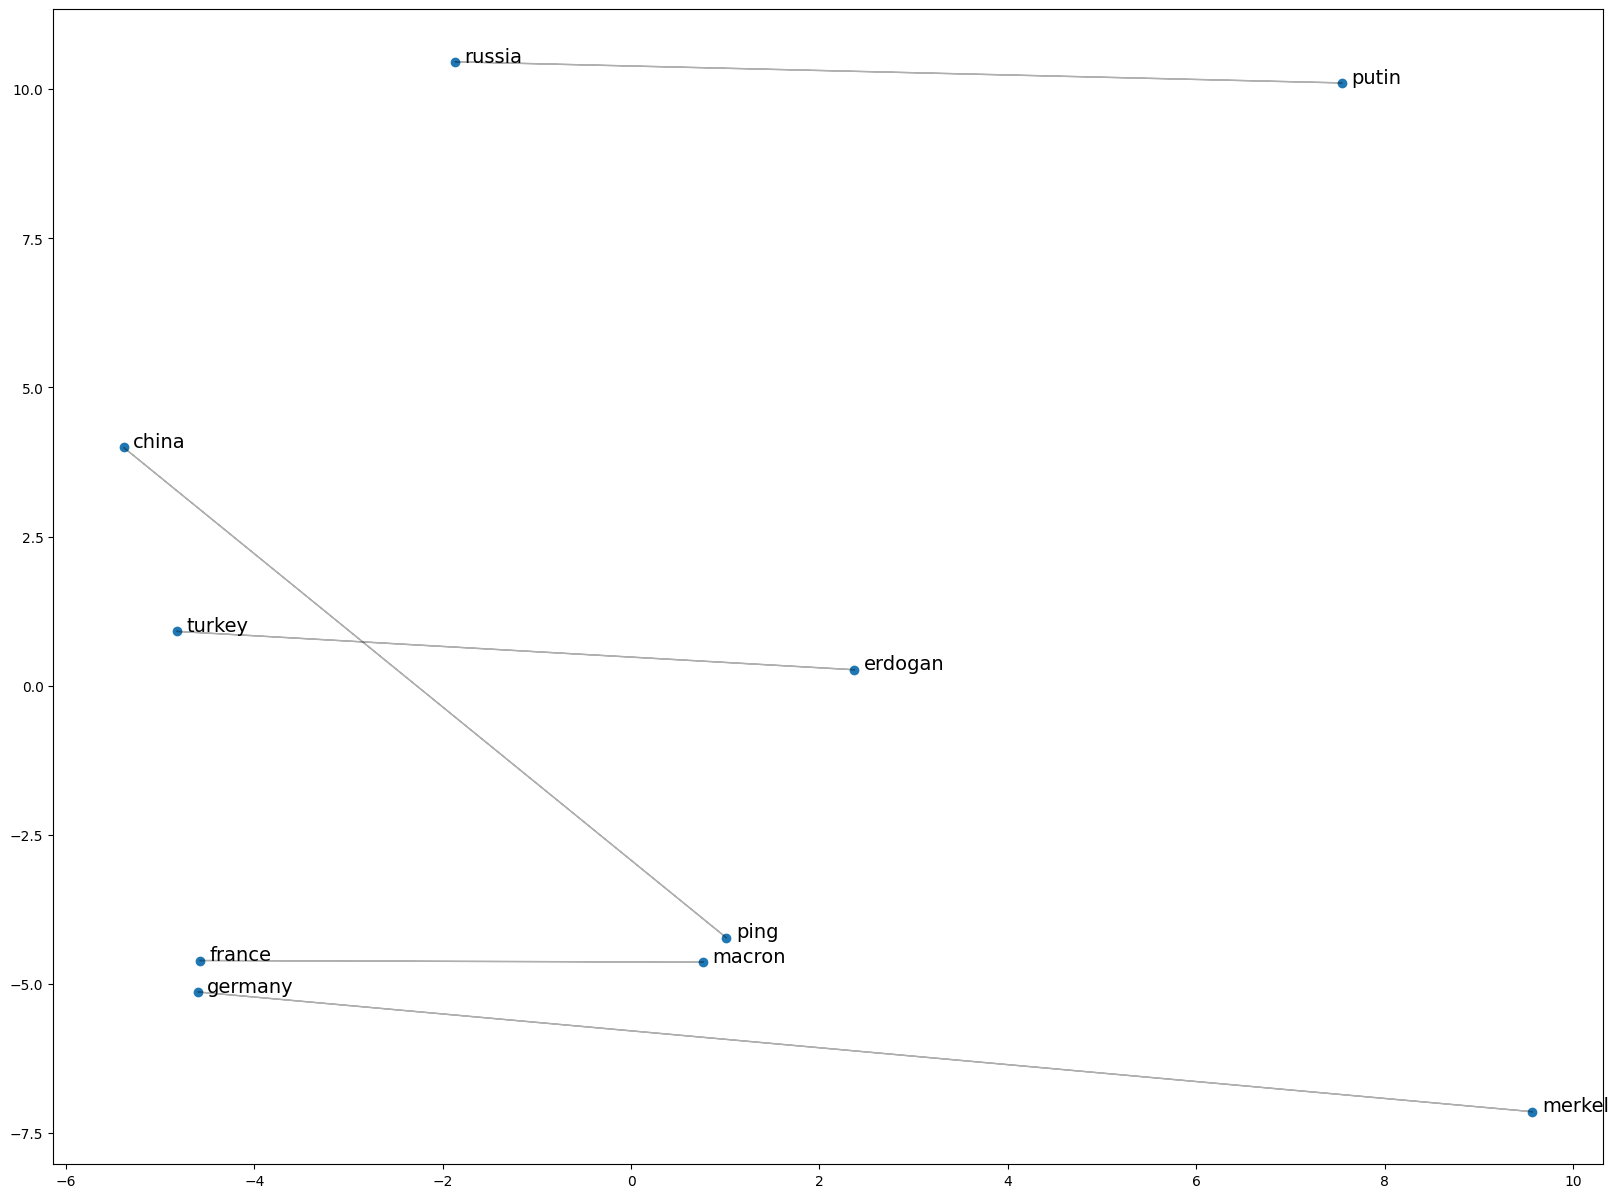

In [20]:
# Obtain embeddings, apply PCA and plot word pair relations
tokens, embeddings = getWordPairEmbeddings(countries_HoS, model)
embeddings_reduced = reduceDimensionality(embeddings, n = 2)
plotWordPair(embeddings_reduced, countries_HoS)

**Discuss your results:**


Most but not all arrows are pointing in a similar direction which points towards the conclusion that the model indeed learned the similar relationship within the word pairs. The relationship is not as clear compared to the figure in the original paper, which can be explained by the less amount of training data, no stopword removal and no finetuned hyperparameters. This leads us to the conclusion that the model was able to capture the similar relationship within the word pairs - arguably a bit better compared to the previous task. 

# Task 3: Doc2vec

In this part, you will work with the Doc2Vec model to create document embeddings. Conceptually, one can create embeddings of documents by averaging, concatenating, or otherwise combinding the embeddings or words in the documents. Of course, there are more advanced methods, of which Doc2vec is one. It is similar to word2vec and won't be discussed in detail in the lecture, but you can find further information in the corresponding paper if you are curious (http://proceedings.mlr.press/v32/le14.pdf). 

For this task, you will train a Doc2Vec model using the gensim api and compare its results to document embeddings that you derive by averaging word2vec vectors. Again, you need the news data as training data. Then, we will have to cluster your document embeddings and compare them to document embeddings obtained by averaging word vectors (using your word2vec model from the previous task).

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Train Doc2vec Model</b> 
</div>

First, you need to preprocess the training data. Please refer to the [gensim documentation](https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html) for detailed information. The [Define a Function to Read and Preprocess Text](https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#define-a-function-to-read-and-preprocess-text) and [Training the Model](https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#training-the-model) sections might be relevant here.

Please implement the following steps:
- Preprocess the data from **all** articles using the gensim.models.doc2vec.TaggedDocument() function yielding a tokenized article and its index.
- Train a Doc2Vec model with default parameters as instructed on the website on **all** articles. With epochs = 10, this should take you ~10 min.

In [21]:
# Read article data
with open("../input/newsdata/relevant_articles.json","rb") as d:
    relevant_articles = json.load(d)

In [22]:
# Preprocess data
articles = pd.json_normalize(relevant_articles)

# Preprocess text
articles["text"] = articles["text"].replace('\n', '')
articles["text_lower"] = articles["text"].str.lower()
print("Articles extracted:", len(articles["text_lower"] ))

# Show some rows
articles.head()

Articles extracted: 60795


,_id,url,title,feed,type,lang,refs,sum,body,text,pub.$date,ret.$date,auth,text_lower
0,197727,http://www.theguardian.com/housing-network/201...,Five steps to fixing the UK housing crisis in ...,guardian,politics,en,[http://www.theguardian.com/commentisfree/2015...,Headlines about the utter madness of our housi...,Perhaps in years to come 2015 will be remember...,Headlines about the utter madness of our housi...,2016-01-01T09:12:27.000+0000,2016-01-01T09:27:32.000+0000,NaN,headlines about the utter madness of our housi...
1,197728,http://www.theguardian.com/commentisfree/2016/...,That’s enough assessments of 2015. It’s time t...,guardian,politics,en,"[http://www.theguardian.com/business/davos, ht...",From Strictly Come Dancing featuring Vladimir ...,• Jeremy Corbyn turns down invitation to atten...,From Strictly Come Dancing featuring Vladimir ...,2016-01-01T09:37:06.000+0000,2016-01-01T09:47:42.000+0000,NaN,from strictly come dancing featuring vladimir ...
2,197995,http://www.theguardian.com/politics/2016/jan/0...,The paperback memoirs of Miss Rice-Davies : ar...,guardian,politics,en,[http://www.theguardian.com/politics/2014/dec/...,1 January 1964 : The Mandy Report turns out to...,"Miss Mandy Rice-Davies, one of 1963’s better k...",1 January 1964 : The Mandy Report turns out to...,2016-01-01T05:00:22.000+0000,2016-01-01T22:59:09.000+0000,NaN,1 january 1964 : the mandy report turns out to...
3,198038,http://www.bbc.co.uk/news/uk-scotland-35210821...,'Very drunk' patient numbers revealed,bbc,politics,en,[http://www.bbc.co.uk/news/uk-scotland-35097230],Ambulances attend more than 60 incidents on av...,"Paramedics treated about 12,000 people who wer...",Ambulances attend more than 60 incidents on av...,2016-01-02T00:42:46.000+0000,2016-01-02T00:45:47.000+0000,NaN,ambulances attend more than 60 incidents on av...
4,198046,http://www.bbc.co.uk/news/uk-35212696#sa-ns_mc...,Littering fines set to rise to £150,bbc,politics,en,[http://www.telegraph.co.uk/news/politics/1206...,Penalties for people who drop litter could rea...,"According to the Daily Telegraph, the minimum ...",Penalties for people who drop litter could rea...,2016-01-02T04:28:41.000+0000,2016-01-02T04:47:52.000+0000,NaN,penalties for people who drop litter could rea...


In [23]:
# Preprocess training data (all articles)

def read_corpus(articles, tokens_only=False):
    for i, article in enumerate(articles):
        tokens = gensim.utils.simple_preprocess(article)
        if tokens_only:
            yield tokens
        else:
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [24]:
# Train Doc2Vec model with default parameters (epochs=10)

# Preprocess Data
train_corpus = list(read_corpus(articles["text_lower"]))

# Define model
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=20)

# Build model vocabulary
model.build_vocab(train_corpus)

# Train model
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

# Optionally save model
model.save("doc2vec_model.h5")

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Generate Document Embeddings</b> 
</div>

Please implement the following steps to get document embeddings for all articles published on 08th November 2016:
- Select all articles' bodies published on 08th November 2016.
- Remove all line breaks from the data.
- Create document embeddings D_doc2vec(**a**) for all news articles **a** on this 
day using the pre-trained doc2vec model from Task 1.
- Create document embeddings D_avg_word2vec(**a**) for all news articles **a** on 08th November 2016
 by averaging word2vec embeddings of all words in the document (use your pre-trained Word2Vec model from Task 1 to get the embeddings)


In [25]:
# Select article from 08th November and pre-process
articles_2016_11_08 = articles[(articles['pub.$date'].str[0:10] == "2016-11-08")]
articles_2016_11_08.index = range(len(articles_2016_11_08.index))
print("Articles extracted:",  len(articles_2016_11_08.index))

Articles extracted: 192


In [26]:
# Load previously trained models
doc2vec_model = gensim.models.Word2Vec.load("./doc2vec_model.h5")
word2vec_model = gensim.models.Word2Vec.load("./word2vec_model.h5")

In [27]:
# Generate list of document embeddings obtained from the Doc2Vec model

articles_doc_embeddings = []

for article in list(articles_2016_11_08["text"]): 
    article_processed = gensim.utils.simple_preprocess(article)
    article_emb = doc2vec_model.infer_vector(article_processed)
    articles_doc_embeddings.append(article_emb)

***

In [28]:
# Generate list of document embeddings obtained by averaging word  
# embeddings of every article based on Word2Vec model from Task 1

articles_avg_embeddings = []

for article in list(articles_2016_11_08["text"]): 
    
    embedding = [0] * 100
    tokens = gensim.utils.simple_preprocess(article)
    
    for token in tokens:
        if token in word2vec_model.wv:
            embedding = embedding + word2vec_model.wv[token]
    
    embedding = embedding / len(tokens)
    articles_avg_embeddings.append(embedding)

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 3: Compare Document Embeddings</b> 
</div>

Now we ask you to find clusters both sets of embeddings to compare their content:
*  As usual, we want to use cosine similarity to compute similarities between embeddings. Since the default k-means implementation of sklearn does not support this, we can use a trick: by standardizing vectors to unit length, we ensure that the euclidean distance function that k-means is using is proportional to the results of cosine similarity (for a detailed explanation, see here: http://mlwiki.org/index.php/Cosine_Similarity). Thus, make sure to normalize all vectors to unit length by using the L2 norm (if this is unfamiliar to you, see here: https://kawahara.ca/how-to-normalize-vectors-to-unit-norm-in-python/)
* For both types of embeddings, cluster the documents with k-means using the sklearn.cluster.KMeans() class. You might have to experiment a bit with the number of clusters depending on how happy you are with your results. We suggest values between k=10 and k=20.
* Print the contents of each cluster in a table containing (1) the cluster id, (2) the title of the article, (3) the news outlet, and (4) the distance of every embedding to its assigned cluster centroid. Sort the table by the cluster id column.
* For both types of embeddings, apply PCA to reduce the embeddings to 2 dimensions. Subsequently visualize the results as scatter plot. Annotate each datapoint with a label of the news outlet which published the article. 
* Discuss the results

In [29]:
def clusterEmbeddings(embeddings, clusters = 15, seed = 0):
    """ Normalize and cluster Embeddings"""
    
    # Normalize
    embeddings = preprocessing.normalize(embeddings, norm='l2')
    
    # Cluster
    result = cluster.KMeans(n_clusters=clusters, random_state=seed).fit(embeddings)
    labels = result.labels_
    centers = result.cluster_centers_
    
    return embeddings, labels, centers

In [30]:
def annotateEmbeddings(articles, embeddings, labels, centers):
    """Returns a dataframe with articles and embeddings"""
    
    titles = []
    feeds = []
    types = []
    cluster = []
    distance = []

    for i, article in articles.iterrows():

        titles.append(article['title'])
        feeds.append(article['feed'])
        types.append(article['type'])
        cluster.append(labels[i])
        distance.append(cosine(embeddings[i], centers[labels[i]]))

    articles = pd.DataFrame({
        "cluster" : cluster,
        "title" : titles,
        "outlet" : feeds,
        "dist_to_center" : distance
    })
    
    return articles


In [31]:
# Cluster embeddings and create table with columns "Distance to centroid", "title", "Assigned cluster", "News outlet"

## Cluster embeddings
avg_emb_norm, avg_emb_labels, avg_emb_centers = clusterEmbeddings(articles_avg_embeddings)
doc_emb_norm, doc_emb_labels, doc_emb_centers = clusterEmbeddings(articles_doc_embeddings)

## Create Tables
results_avg_embeddings = annotateEmbeddings(articles_2016_11_08, avg_emb_norm, avg_emb_labels, avg_emb_centers)
results_doc_embeddings = annotateEmbeddings(articles_2016_11_08, doc_emb_norm, doc_emb_labels, doc_emb_centers)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [32]:
# Print table for doc embeddings generated with the doc2vec model
results_doc_embeddings.sort_values(by=['cluster'])

,cluster,title,outlet,dist_to_center
30,0,"When the world’s so confused, should we just k...",guardian,0.278342
33,0,Theresa May’s India trip reveals much about wh...,guardian,0.357001
103,0,PC? Just call it political politeness. Even ri...,guardian,0.307859
99,0,Remembrance of atrocities won’t save us from p...,guardian,0.267734
86,0,Meghan Markle and Gina Miller don’t recognise ...,guardian,0.321198
...,...,...,...,...
64,14,The moment Bill and Hillary Clinton stood perf...,CBS,0.246367
67,14,Timeline of the last day of the 2016 president...,CBS,0.304279
142,14,This little known agency head will be the firs...,WP,0.422917
1,14,9 viral moments from the 2016 presidential ele...,CBS,0.303544


In [33]:
# Print table for doc embeddings generated by averaging word embeddings
results_avg_embeddings.sort_values(by=['cluster'])

,cluster,title,outlet,dist_to_center
157,0,Child abuse judge: I will not give evidence,Skynews,0.024057
160,0,Liz Truss confronted by Tory MPs over handling...,guardian,0.033907
35,0,Lowell Goddard: Home Office failed to defend m...,guardian,0.031545
58,0,Liz Truss swore to defend the judiciary. But s...,guardian,0.043004
164,0,Dame Lowell Goddard won't appear before Home A...,bbc,0.046773
...,...,...,...,...
138,14,LA county elections boss criticized amid voter...,Fox,0.054182
80,14,Voters cover Susan B. Anthony's tombstone with...,WP,0.228398
129,14,Document reportedly shows Marine vet running f...,Fox,0.207265
113,14,Trump files lawsuit in Nevada over early voting,CBS,0.038405


In [34]:
print("Average dist to centroid using DOC embeddings:", results_doc_embeddings['dist_to_center'].mean(axis = 0))
print("Average dist to centroid using AVG embeddings:", results_avg_embeddings['dist_to_center'].mean(axis = 0))

Average dist to centroid using DOC embeddings: 0.3402315607987158
Average dist to centroid using AVG embeddings: 0.06092129430017997


In [35]:
pca = PCA(n_components=2)
pca.fit(doc_emb_norm)
doc_emb_trans = pca.transform(doc_emb_norm)

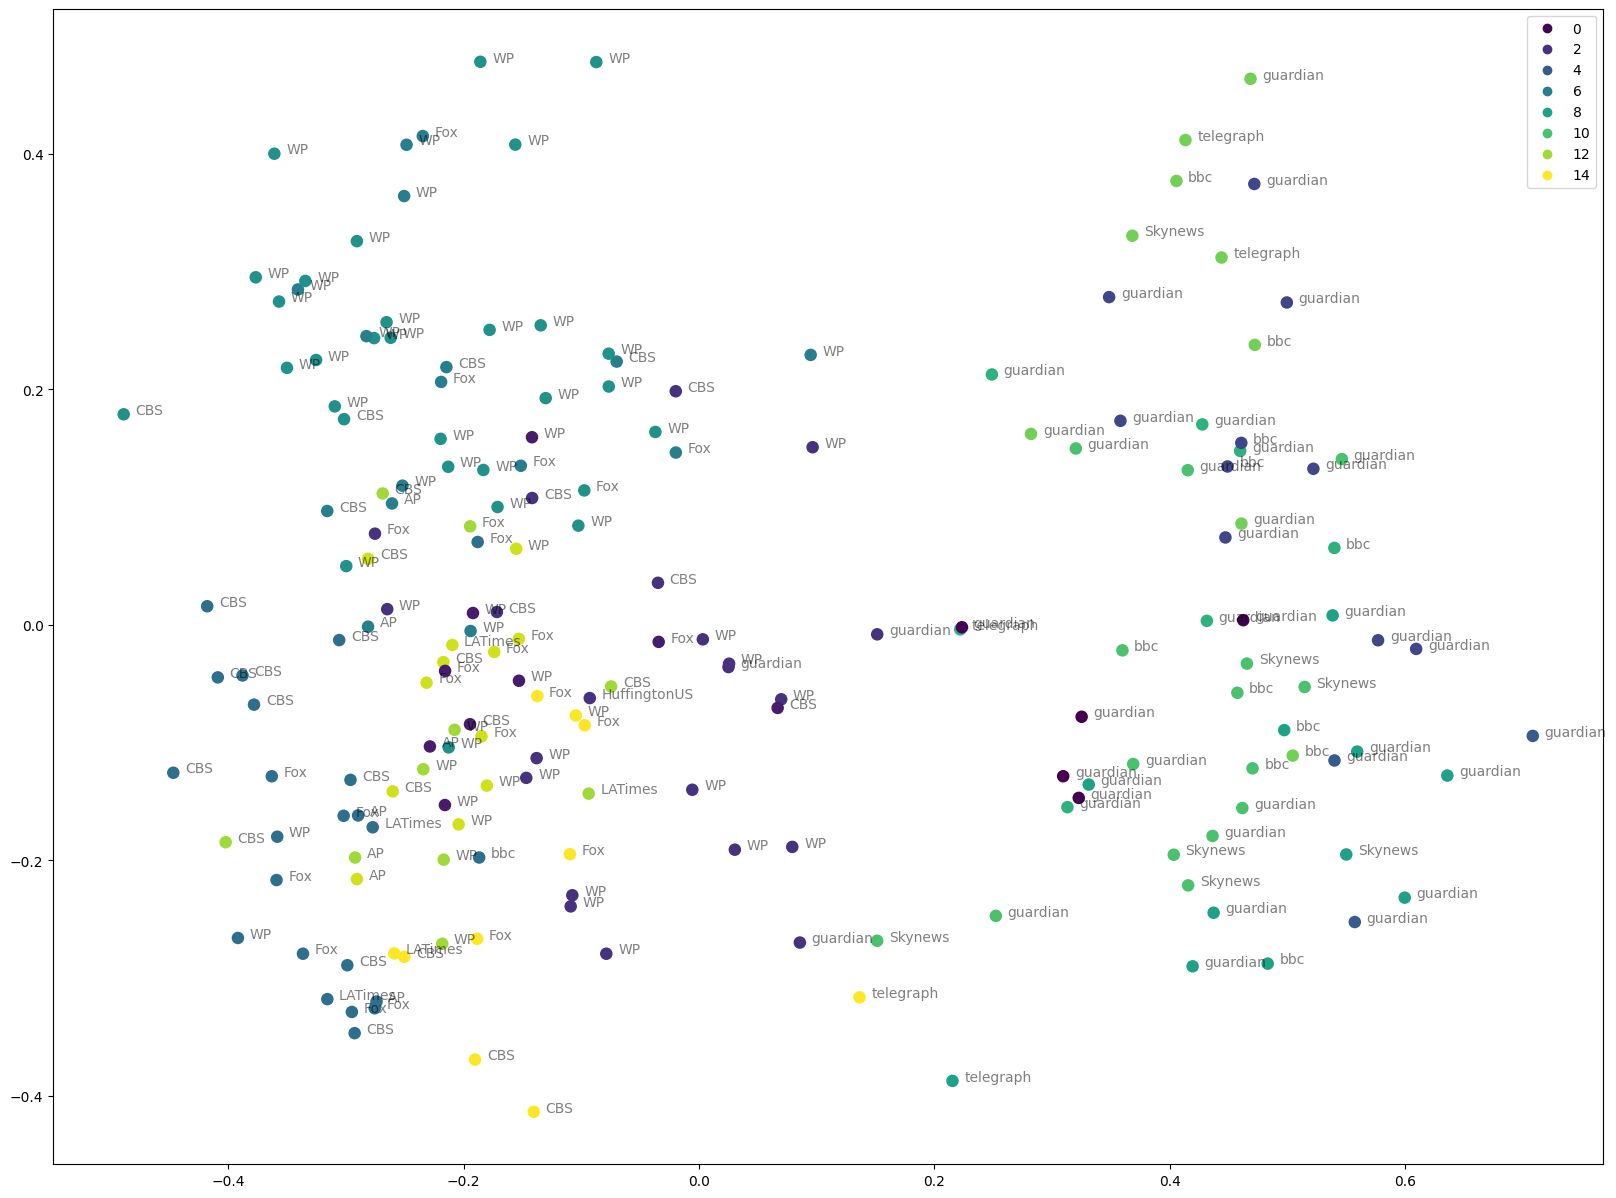

In [36]:
# Plot
plt.rcParams["figure.figsize"] = (20,15)
scatter = plt.scatter(x = doc_emb_trans[:,0], 
            y = doc_emb_trans[:,1],
            c = results_doc_embeddings['cluster'],
            s = 64)

article_doc_feeds = results_doc_embeddings['outlet']

for i, embedding in enumerate(doc_emb_trans):
    plt.annotate(article_doc_feeds[i], (embedding[0], embedding[1]),
                 xytext=(embedding[0] + 0.01, embedding[1]),
                 fontsize=10, alpha = 0.5)
            
plt.legend(*scatter.legend_elements())

plt.show()

In [37]:
pca = PCA(n_components=2)
pca.fit(avg_emb_norm)
avg_emb_trans = pca.transform(avg_emb_norm)

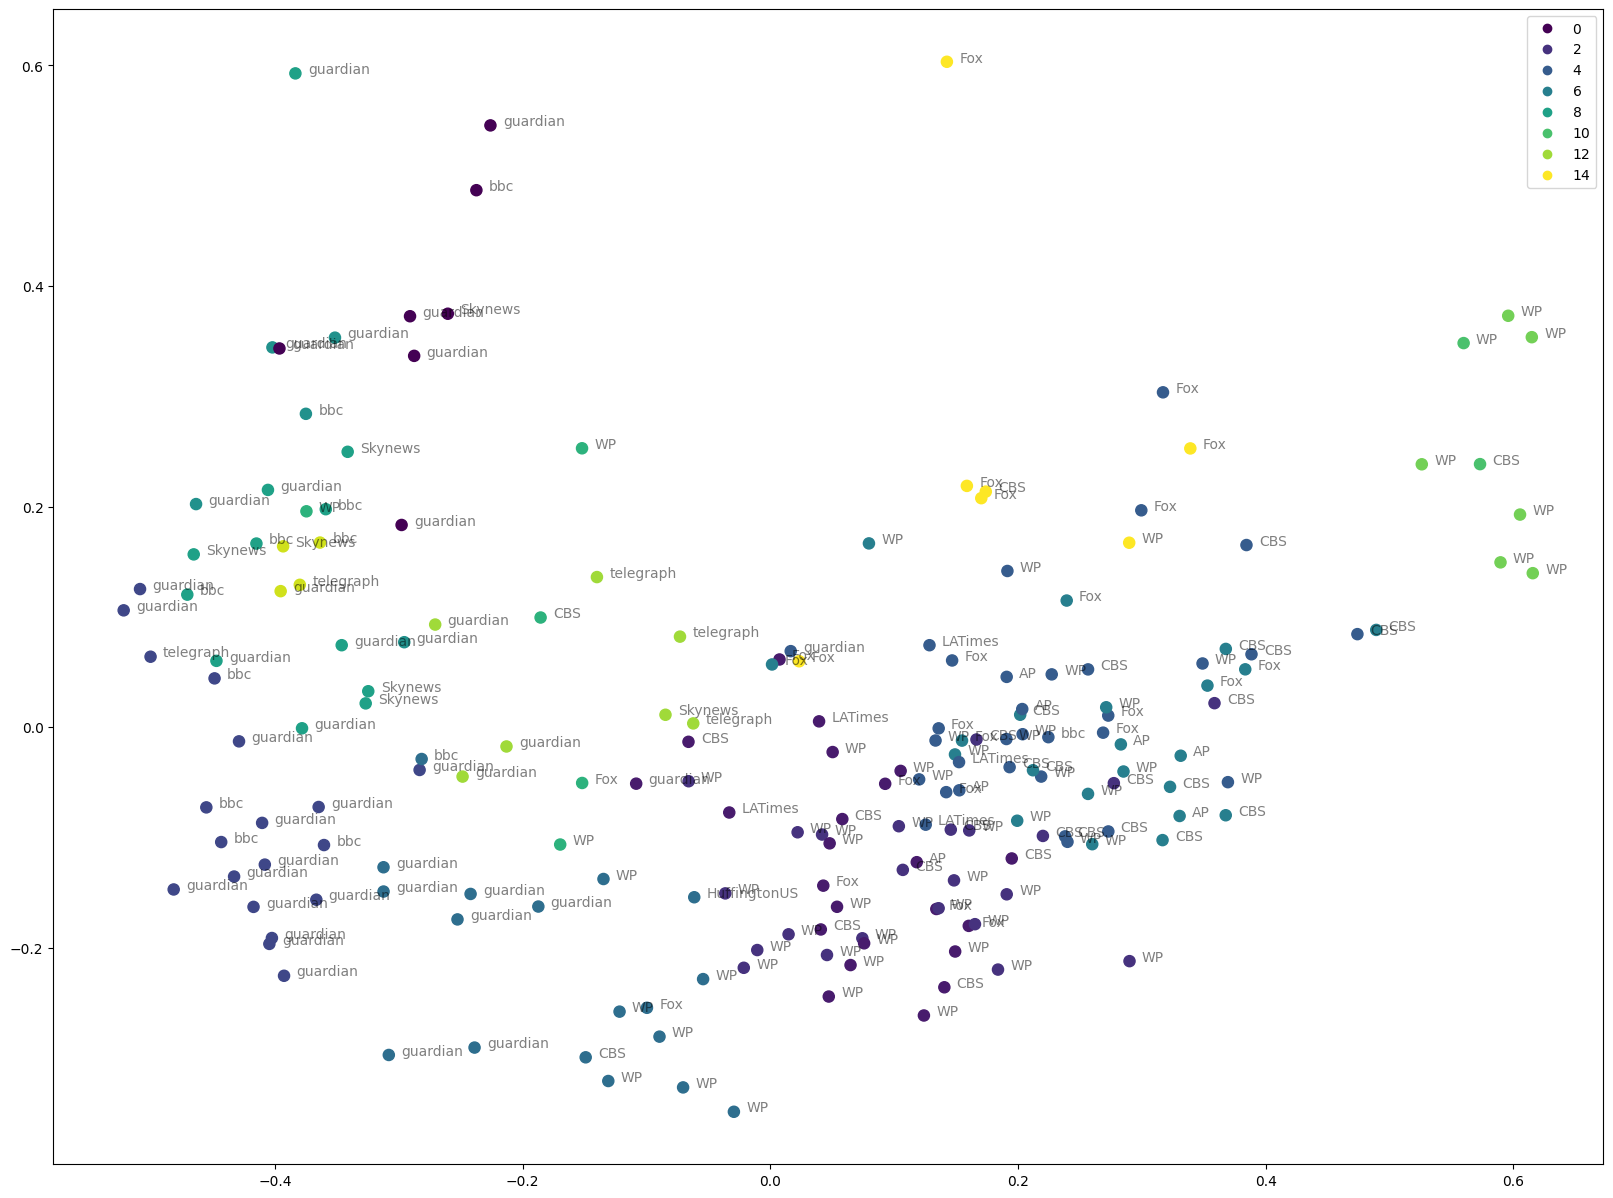

In [38]:
# Plot
plt.rcParams["figure.figsize"] = (20,15)
scatter = plt.scatter(x = avg_emb_trans[:,0], 
            y = avg_emb_trans[:,1],
            c = results_avg_embeddings['cluster'],
            s = 64)

article_avg_feeds = results_avg_embeddings['outlet']

for i, embedding in enumerate(avg_emb_trans):
    plt.annotate(article_avg_feeds[i], (embedding[0], embedding[1]),
                 xytext=(embedding[0] + 0.01, embedding[1]),
                 fontsize=10, alpha = 0.5)
            
plt.legend(*scatter.legend_elements())

plt.show()

**Discuss your results: can you see any differences comparing the Doc embeddings obtained from Doc2Vec and the averaged embeddings? Also, can you see any meaningful clustering by content? Also consider the news outlets and their role in providing content**

Possibly unexpectedly, the averaged word vectors produce better clustering results. This can be seen from the lower average deviation from the cluster centoid as well as from a visual analysis of the scatterplots. However, it is of interest is the patterns with regard to the news outlets. The outlets CBS, WP, Fox as well as the outlets bbc, guardian respectively seem to publish similar articles.